In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Font modification
#plt.rcParams['font.sans-serif'] = "Times New Roman"
#plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 18


In [3]:
# Use with caution
if True:
    import warnings
    warnings.filterwarnings("ignore")

# Data loading and assembly

In [4]:
spectra = pd.read_csv('../data/cleanedset.csv')
columns = ['target', 'sampleID'] 
columns.extend([str(x) for x in range(950, 1530+1,2)])
spectra = spectra[columns]
print(spectra.shape)
spectra.head()

(591, 293)


,target,sampleID,950,952,954,956,958,960,962,964,...,1512,1514,1516,1518,1520,1522,1524,1526,1528,1530
0,94.333333,0.0,36.723839,35.745964,34.811623,33.955212,33.197552,32.570518,32.147972,31.807793,...,0.791820,0.831189,0.883438,0.940272,0.993729,1.046867,1.098642,1.152454,1.215338,1.271571
1,94.333333,0.0,36.369366,35.383987,34.443897,33.584080,32.823158,32.192280,31.770844,31.431589,...,0.685869,0.728103,0.785778,0.845810,0.902551,0.961095,1.017545,1.073209,1.138063,1.196826
2,94.333333,0.0,35.385422,34.405182,33.466976,32.614578,31.862633,31.242191,30.828016,30.496775,...,0.618997,0.659589,0.712821,0.769303,0.822148,0.875681,0.929040,0.979519,1.040625,1.100850
3,94.333333,0.0,35.121685,34.145687,33.217796,32.374218,31.630789,31.019081,30.611959,30.286642,...,0.751016,0.796110,0.852175,0.909087,0.965727,1.024710,1.080235,1.133445,1.197904,1.262516
4,76.333333,1.0,36.185947,35.209904,34.280155,33.430157,32.679989,32.062084,31.647160,31.312046,...,1.001077,1.051815,1.112780,1.175900,1.240040,1.304035,1.365576,1.426388,1.495515,1.561842


# Regression

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union

## Folds definition

In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False, random_state=47)

## Split definition

In [7]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(spectra[[str(x) for x in range(950, 1530+1,2)]], spectra['target'], test_size=0.33, random_state=53)

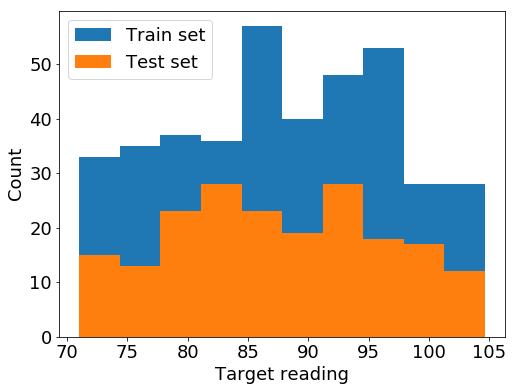

In [14]:
plt.figure(figsize=(8, 6))
plt.hist(y_train, label='Train set')
plt.hist(y_test, label='Test set')
plt.legend()
plt.xlabel('Target reading')
plt.ylabel('Count')
plt.savefig('train vs test.png', bbox_inches = 'tight')
plt.show()

## Data trimmer

In [18]:
class Trimmer(BaseEstimator, TransformerMixin):
    """Apply a lambda feature"""
    def __init__(self,wavemin=950, wavemax=1530):# 
        self.wavemin = wavemin
        self.wavemax = wavemax
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        colnames = [str(x) for x in range(self.wavemin, self.wavemax+1,2)]
        return X[colnames]

params={'wavemin':992, 'wavemax':1200,}
trimmer = Trimmer(**params)
Xtr = trimmer.fit_transform(X_train)
Xtr.shape

(395, 105)

## Savgol filter

https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter

In [20]:
from scipy.signal import savgol_filter

class Savgol(BaseEstimator, TransformerMixin):
    """Apply a lambda feature"""
    def __init__(self, window_length=5, polyorder=2, deriv=0):# 
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy(deep=True)
        toreturn = df.apply(savgol_filter, args=(self.window_length, self.polyorder, self.deriv,1. , 0, 'nearest'), axis=1, raw=True, result_type='broadcast')
        return toreturn

params={'window_length':27, 'polyorder':2, 'deriv':2}
savgol = Savgol(**params)
Xtr = savgol.fit_transform(X_train)
Xtr.shape

(395, 291)

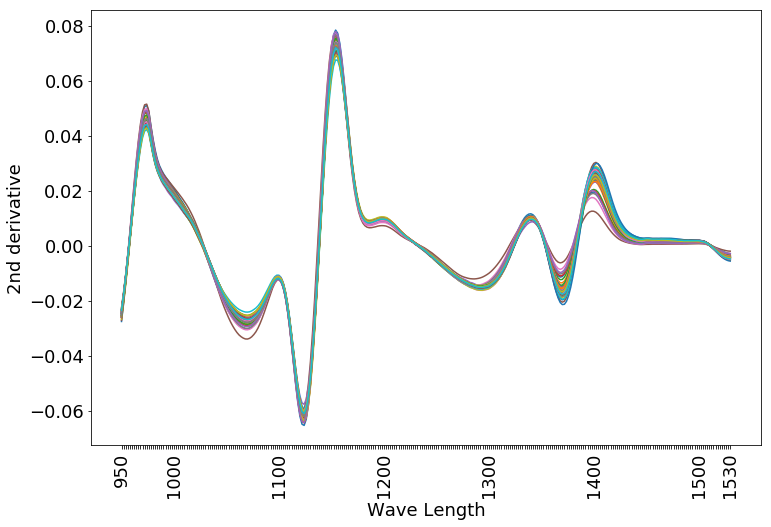

In [21]:
df = savgol.transform(X_train)
df.head(50).T.plot(legend=None, figsize=(12,8))
#plt.title('Spectras - 1rst derivative')
plt.xlabel('Wave Length') #,fontname="Times New Roman", fontsize=18
plt.ylabel('2nd derivative')
#plt.yticks(fontname="Times New Roman", fontsize=18)
#plt.xticks(fontname="Times New Roman", fontsize=18)

plt.xticks(np.arange(len(df.columns)), [v if (int(v) % 100 == 0) or k==0 or k==len(df.columns)-1 else '' for (k,v) in enumerate(df.columns)], rotation=90)
plt.savefig('genera - raw Spectras - 2nd derivative.png')
plt.show()

## Log(1/(p+n))

In [22]:
class Log1overN(BaseEstimator, TransformerMixin):
    def __init__(self, n=1):# 
        self.n = n
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy(deep=True)
        toreturn = df.apply(lambda x:np.log(1/(x+self.n)), axis=0)
        return toreturn

log1over = Log1overN(n=3)
log1over.fit_transform(X_train).shape

(395, 291)

## SNV

In [23]:
class Snv(BaseEstimator, TransformerMixin):
    def __init__(self,):# 
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        data_snv = np.zeros_like(X.values)
        for i in range(X.shape[0]):
            # Apply correction
            data_snv[i,:] = (X.values[i,:] - np.mean(X.values[i,:])) / np.std(X.values[i,:])
        return pd.DataFrame(data_snv, columns=X.columns, index=X.index)

snv = Snv()
snv.fit_transform(X_train).shape

(395, 291)

## Blocs creation

In [25]:
trimmer = Trimmer()

In [26]:
params={'window_length':13, 'polyorder':3, 'deriv':2}
savgol = Savgol(**params)

In [27]:
snv = Snv()

In [28]:
log1over = Log1overN(n=3)

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [30]:
from sklearn.decomposition import PCA
pca = PCA()

# Tree construction

In [31]:
lrpipelist1 = [#
                ('trimmer', trimmer),
               ('snv', snv),
               ('savgol', savgol),
               ('log1over', log1over),
               ('scaler', scaler),
               ('pca', pca),
                ] #
pipe1 = Pipeline(lrpipelist1)
#Xtrans = pipe1.fit_transform(spectra)#.shape

In [32]:
pipe1.fit_transform(X_train).shape

(395, 291)

In [33]:
from sklearn.linear_model import ElasticNet
elnet = ElasticNet(random_state=0, max_iter=10000)

In [34]:
listpipereg = [('pipe1', pipe1), ('elnet', elnet)] #
pipereg = Pipeline(listpipereg)

In [35]:
pipereg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pipe1', Pipeline(memory=None,
     steps=[('trimmer', Trimmer(wavemax=1530, wavemin=950)), ('snv', Snv()), ('savgol', Savgol(deriv=2, polyorder=3, window_length=13)), ('log1over', Log1overN(n=3)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, i...e=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False))])

### HyperOpt

In [36]:
pipe1.get_params().keys()

dict_keys(['memory', 'steps', 'trimmer', 'snv', 'savgol', 'log1over', 'scaler', 'pca', 'trimmer__wavemax', 'trimmer__wavemin', 'savgol__deriv', 'savgol__polyorder', 'savgol__window_length', 'log1over__n', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten'])

In [37]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [38]:
from sklearn.metrics import r2_score

In [62]:
counter = 0
bestscore = 1e20


trainscore = True

def objective(params):
    #print(params)
    global counter
    global bestscore
    counter += 1
    
    hyperparams = {
        'alpha': params['alpha'],
        'l1_ratio': params['l1_ratio'],
        'random_state': 0,
        }
    
    lrpipelist1 = [('trimmer', trimmer), ]
    if pipeoption[0] == True:
        lrpipelist1.append(('snv', snv))
    if pipeoption[1] == True:
        lrpipelist1.append(('savgol', savgol))
    if pipeoption[2] == True:
        lrpipelist1.append(('log1over', log1over))
    if pipeoption[3] == True:
        lrpipelist1.append(('scaler', scaler))
    if pipeoption[4] == True:
        lrpipelist1.append(('pca', pca))

    pipe1 = Pipeline(lrpipelist1)

    pipe1.set_params(pca__n_components=int(component))
    pipe1.set_params(savgol__window_length=int(params['savgol__window_length'])+1)
    pipe1.set_params(savgol__deriv=int(params['savgol__deriv']))
    pipe1.set_params(trimmer__wavemin=int(params['trimmer__wavemin']))
    pipe1.set_params(trimmer__wavemax=int(params['trimmer__wavemax']))
    pipe1.set_params(savgol__polyorder=int(params['savgol__polyorder']))
    
    Xtrans = pipe1.fit_transform(X_train)
    
    elnet = ElasticNet(**hyperparams)
    
    if trainscore:
        preds = cross_val_predict(elnet, Xtrans, y_train, cv=kf, n_jobs=-2)
        score = mean_squared_error(y_train , preds)
        score = -r2_score(y_train, preds)
    else:
        Xtranstest = pipe1.transform(X_test)
        elnet.fit(Xtrans, y_train)
        preds = elnet.predict(Xtranstest)
        score = mean_squared_error(y_test , preds)
        #score = -r2_score(y_test , preds)
    
    
    #score = -cross_val_score(regpip, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-2).mean()
    if counter % 50 == 0:
        #print("{} - MSECV {}".format(counter, score))
        #print(params)
        pass
    if score < bestscore:
        bestscore = score
        #print("{} - MSECV {} - {}".format(counter, score, params))
    
    return score

sequence = ('SNV', 'SAVGOL', 'LOG 1/p')
pipeoptions = [#[True, True, True, True, True], #SNV - SAVGOL - LOG1p - SCALER - PCA
                #[True, True, False, True, True], # No log1p
                [False, True, True, True, True],  #No SNV
                [False, True, False, True, True], #No SNV or log1p
                ]

space = {
    'alpha': hp.loguniform('alpha', -3, 2),
    'l1_ratio': hp.uniform('l1_ratio', 0.5, 1),
    'savgol__window_length': hp.quniform('savgol__window_length', 3, 19, 2),
    'savgol__deriv':hp.quniform('savgol__deriv', 0, 2, 1),
    'trimmer__wavemin': hp.quniform('trimmer__wavemin', 950, 1200, 2),
    'trimmer__wavemax': hp.quniform('trimmer__wavemax', 1300, 1530, 2),
    'savgol__polyorder':hp.quniform('savgol__polyorder', 2, 3, 1),
}

bestscores = []
pcacomp = {}
components = [5, 8, 10, 15]

for component in components:
    for pipeoption in pipeoptions:
        #print(pipeoption, component)
        #print()
        counter = 0
        bestscore = 1e20
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=500)
        print(component, '-->', pipeoption, bestscore, best)
        bestscores.append((pipeoption, bestscore, best))
    pcacomp[component] = bestscores
    bestscores = []

5 --> [False, True, True, True, True] -0.6134247605810381 {'alpha': 0.06770099338994064, 'l1_ratio': 0.847017429293049, 'savgol__deriv': 2.0, 'savgol__polyorder': 3.0, 'savgol__window_length': 10.0, 'trimmer__wavemax': 1300.0, 'trimmer__wavemin': 1168.0}
5 --> [False, True, False, True, True] -0.6040194083135226 {'alpha': 0.7014644331430235, 'l1_ratio': 0.6992653920739325, 'savgol__deriv': 2.0, 'savgol__polyorder': 2.0, 'savgol__window_length': 16.0, 'trimmer__wavemax': 1354.0, 'trimmer__wavemin': 1162.0}
8 --> [False, True, True, True, True] -0.6791877038731018 {'alpha': 0.18520141726707648, 'l1_ratio': 0.9646452419486129, 'savgol__deriv': 2.0, 'savgol__polyorder': 3.0, 'savgol__window_length': 8.0, 'trimmer__wavemax': 1342.0, 'trimmer__wavemin': 1034.0}
8 --> [False, True, False, True, True] -0.6847737591470007 {'alpha': 0.0934724285373248, 'l1_ratio': 0.9395470135994377, 'savgol__deriv': 2.0, 'savgol__polyorder': 2.0, 'savgol__window_length': 10.0, 'trimmer__wavemax': 1344.0, 'trimm

In [63]:
#pcacomp

In [64]:
cleaned = {comp:results[np.argmin([x[1] for x in results])] for comp, results in pcacomp.items()}
cleaned = [{**v[2], 'pca':k, 'SNV':v[0][0], 'savgol':v[0][1], 'log1op':v[0][2]} for k, v in cleaned.items()]
#cleaned

In [65]:

dataset = pd.DataFrame(cleaned)#.set_index('pca')

errors = [1 ,2 ,3 ,4 ,6 ,8, 10]

dataset = dataset.join(pd.DataFrame({'RMSE CV train':[np.nan], 'RMSE test':[np.nan],
                             'R2 CV train':[np.nan], 'R2 test':[np.nan],
                           #**{'Pred +/- {}'.format(x):[np.nan] for x in errors}
                              }))

dataset.T

,0,1,2,3
SNV,False,False,False,False
alpha,0.067701,0.0934724,0.0500212,0.0743762
l1_ratio,0.847017,0.939547,0.919187,0.575318
log1op,True,False,True,True
pca,5,8,10,15
savgol,True,True,True,True
savgol__deriv,2,2,2,2
savgol__polyorder,3,2,3,2
savgol__window_length,10,10,18,14
trimmer__wavemax,1300,1344,1408,1436


In [66]:
for index, best in dataset.iterrows():
    lrpipelist1 = [('trimmer', Trimmer(wavemin=int(best.trimmer__wavemin), wavemax=int(best.trimmer__wavemax))), ]

    if best.SNV:
        lrpipelist1.append(('snv', snv))
    lrpipelist1.append(('savgol', Savgol(window_length=int(best.savgol__window_length)+1, polyorder=int(best.savgol__polyorder), deriv=int(best.savgol__deriv), )))
    if best.log1op:
        lrpipelist1.append(('log1over', log1over))
    lrpipelist1.append(('scaler', scaler))
    lrpipelist1.append(('pca', PCA(n_components=int(best.pca))))

    pipe1 = Pipeline(lrpipelist1)
    
    params = {
        'alpha': best.alpha,
        'l1_ratio': best.l1_ratio,
        'random_state': 0,
        }

    elnet = ElasticNet(**params)
    
    Xtrans = pipe1.fit_transform(X_train)
    preds_train = cross_val_predict(elnet, Xtrans, y_train, cv=kf, n_jobs=-2)
    
    #Fit with best parameters
    elnet.fit(Xtrans, y_train)
    Xtranstest = pipe1.transform(X_test)
    preds_test = elnet.predict(Xtranstest)

    
    dataset['RMSE CV train'].loc[index] = (mean_squared_error(y_train, preds_train, ))**.5
    dataset['RMSE test'].loc[index]     = (mean_squared_error(y_test, preds_test, ))**.5
    dataset['R2 CV train'].loc[index]   = r2_score(y_train, preds_train)
    dataset['R2 test'].loc[index]       = r2_score(y_test, preds_test)
    
    for error in errors:
        pass

In [68]:
dataset.set_index('pca').T.to_csv('../data/elnet_analysis.csv')
dataset.set_index('pca').T

pca,5,8,10,15
SNV,False,False,False,False
alpha,0.067701,0.0934724,0.0500212,0.0743762
l1_ratio,0.847017,0.939547,0.919187,0.575318
log1op,True,False,True,True
savgol,True,True,True,True
savgol__deriv,2,2,2,2
savgol__polyorder,3,2,3,2
savgol__window_length,10,10,18,14
trimmer__wavemax,1300,1344,1408,1436
trimmer__wavemin,1168,1168,1200,1032
